Date: 2016-10-28

In [189]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import sys
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sys.path.append('../src/')
import data_processing
import ripple_decoding
import ripple_detection

In [2]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

epoch_info = data_processing.make_epochs_dataframe(animals, days)
tetrode_info = data_processing.make_tetrode_dataframe(animals)
epoch_index = (epoch_info
    .loc[(['HPa'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'].index)[0]

tetrode_info = data_processing.make_tetrode_dataframe(animals)
area_critera = tetrode_info[epoch_index].area.isin(['CA1', 'CA3']) & \
    ~tetrode_info[epoch_index].descrip.isin(['CA1Ref', 'CA3Ref'])
tetrode_indices = (tetrode_info[epoch_index][area_critera] # Get cell-layer CA1, CA3 LFPs
                       .index.tolist())
CA1_lfps = list(data_processing.get_LFP_data(tetrode_indices, animals).values())

## Karlsson method

Method from Karlsson et al. 2009

#### Test Smooth Envelope

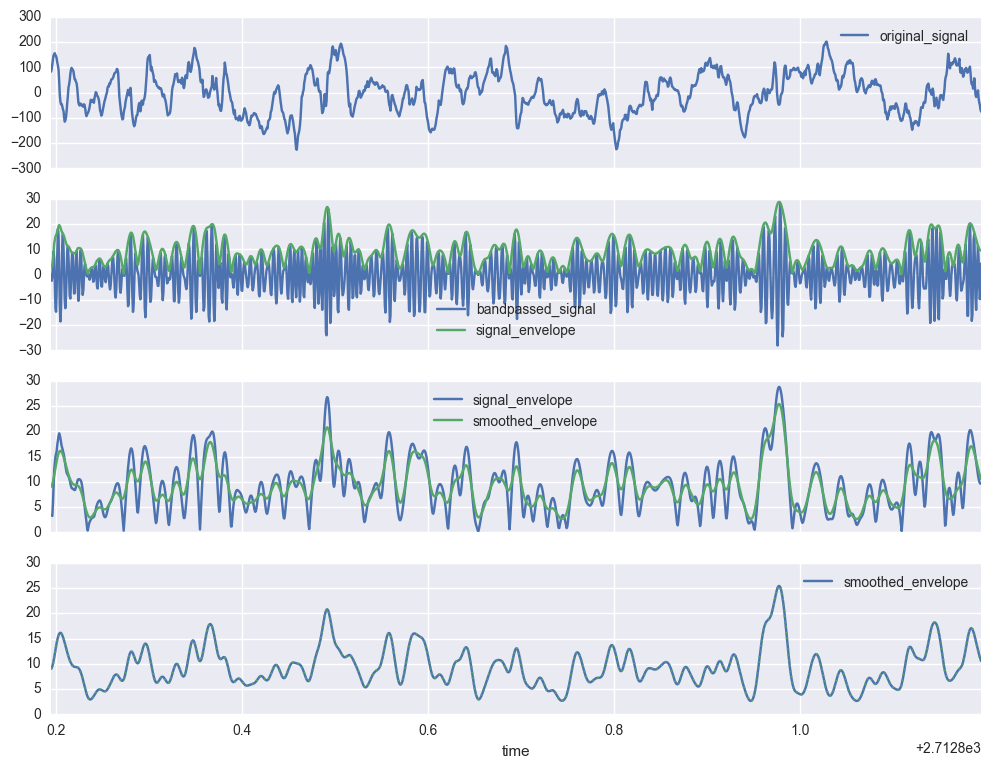

In [64]:
def smoothed_envelope(lfp):
    return pd.DataFrame(
        {'original_signal': lfp.values.flatten(),
         'bandpassed_signal': ripple_detection._ripple_bandpass_filter(lfp.values.flatten()),
         'signal_envelope': ripple_detection._get_envelope(
                ripple_detection._ripple_bandpass_filter(lfp.values.flatten())),
         'smoothed_envelope': ripple_detection._smooth(
                ripple_detection._get_envelope(
                    ripple_detection._ripple_bandpass_filter(lfp.values.flatten())),
                sigma=0.004, sampling_frequency=1500)
        }, index=lfp.index)

filtered_df = smoothed_envelope(CA1_lfps[0])
filtered_df2 = ripple_detection._get_smoothed_envelope(CA1_lfps[0], sigma=0.004, sampling_frequency=1500)

fig, axes = plt.subplots(4, sharex=True, figsize=(12,9))
filtered_df.iloc[0:1500].plot(y='original_signal', ax=axes[0])

filtered_df.iloc[0:1500].plot(y='bandpassed_signal', ax=axes[1])
filtered_df.iloc[0:1500].plot(y='signal_envelope', ax=axes[1])

filtered_df.iloc[0:1500].plot(y='signal_envelope', ax=axes[2])
filtered_df.iloc[0:1500].plot(y='smoothed_envelope', ax=axes[2])

filtered_df.iloc[0:1500].plot(y='smoothed_envelope', ax=axes[3])
filtered_df2.iloc[0:1500].plot(ax=axes[3], linestyle=':')

#### Test z-scoring and threshold detetction

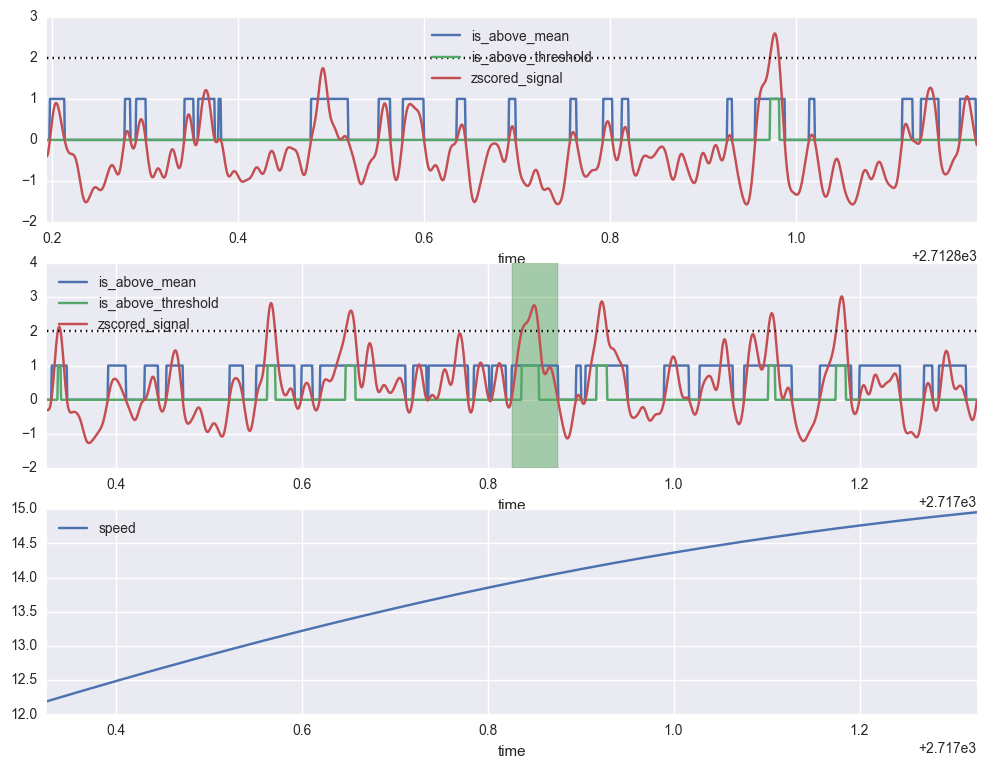

In [124]:
zscored_lfp = ripple_detection._zscore(filtered_df2).values.flatten()
thresholded_lfp = ripple_detection._threshold_by_zscore(filtered_df2, zscore_threshold=2)
extended_lfp = ripple_detection._extend_threshold_to_mean(
                    thresholded_lfp.is_above_mean,
                    thresholded_lfp.is_above_threshold,
                    minimum_duration=0.015)

fig, axes = plt.subplots(3, figsize=(12,9))
pd.DataFrame({'zscored_signal': zscored_lfp, 
              'is_above_mean': thresholded_lfp.is_above_mean,
              'is_above_threshold': thresholded_lfp.is_above_threshold
             }).iloc[0:1500].plot(ax=axes[0])
axes[0].axhline(2, color='black', linestyle=':')

candidate_ripple_start, candidate_ripple_end = list(sorted(extended_lfp))[0]
pd.DataFrame({'zscored_signal': zscored_lfp, 
              'is_above_mean': thresholded_lfp.is_above_mean,
              'is_above_threshold': thresholded_lfp.is_above_threshold
             }).loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500, :].plot(ax=axes[1])
axes[1].axvspan(candidate_ripple_start, candidate_ripple_end, facecolor='green', alpha=0.3)
axes[1].axhline(2, color='black', linestyle=':')

position_df = data_processing.get_interpolated_position_dataframe(epoch_index, animals)
position_df.loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500, :].plot(y='speed', ax=axes[2])

In [17]:
ripple_detection.Karlsson_method(CA1_lfps)

[(2715.7014666666664, 2715.7681333333335),
 (2717.1614666666665, 2717.2174666666665),
 (2717.6314666666667, 2717.6654666666668),
 (2717.7054666666668, 2717.7554666666665),
 (2717.8261333333335, 2717.8987999999999),
 (2717.9067999999997, 2717.9381333333331),
 (2718.0094666666664, 2718.0834666666665),
 (2718.1474666666668, 2718.1947999999998),
 (2718.4681333333333, 2718.5081333333333),
 (2718.6828, 2718.7447999999999),
 (2718.8314666666665, 2718.9481333333333),
 (2719.0967999999998, 2719.1248000000001),
 (2719.2467999999999, 2719.2768000000001),
 (2719.3034666666667, 2719.3894666666665),
 (2719.8247999999999, 2719.9201333333331),
 (2720.2761333333333, 2720.3734666666664),
 (2720.4061333333334, 2720.4434666666666),
 (2720.6421333333333, 2720.6881333333331),
 (2720.7647999999999, 2720.7974666666664),
 (2721.1274666666668, 2721.1694666666667),
 (2721.2661333333331, 2721.3128000000002),
 (2721.3467999999998, 2721.4288000000001),
 (2721.4367999999999, 2721.5448000000001),
 (2721.5574666666666

In [131]:
ripple_detection._exclude_movement_during_ripples(ripple_detection.Karlsson_method(CA1_lfps),
                                                  epoch_index, animals, 4)

[(2723.3961333333332, 2723.4668000000001),
 (2726.8568, 2726.8821333333331),
 (2726.9548, 2726.9888000000001),
 (2731.7821333333331, 2731.8241333333331),
 (2743.2608, 2743.3521333333333),
 (2751.0494666666664, 2751.0821333333333),
 (2751.3174666666664, 2751.3794666666668),
 (2751.8221333333331, 2751.8581333333332),
 (2752.8541333333333, 2752.9014666666667),
 (2753.6754666666666, 2753.7208000000001),
 (2753.7254666666668, 2753.7821333333331),
 (2754.9708000000001, 2755.0394666666666),
 (2758.6841333333332, 2758.7721333333334),
 (2758.8981333333331, 2758.9381333333331),
 (2759.0214666666666, 2759.0921333333331),
 (2760.8154666666665, 2760.8434666666667),
 (2763.6334666666667, 2763.6681333333331),
 (2765.7301333333335, 2765.8061333333335),
 (2766.2494666666666, 2766.3214666666668),
 (2766.7341333333334, 2766.7621333333332),
 (2766.8541333333333, 2766.9081333333334),
 (2767.1361333333334, 2767.2154666666665),
 (2770.9954666666667, 2771.0708),
 (2771.0754666666667, 2771.1967999999997),
 (27

In [132]:
ripple_times = ripple_detection.get_epoch_ripples(epoch_index, animals, sampling_frequency=1500,
                                   ripple_detection_function=ripple_detection.Karlsson_method)
ripple_times

[(2723.3961333333332, 2723.4668000000001),
 (2726.8568, 2726.8821333333331),
 (2726.9548, 2726.9888000000001),
 (2731.7821333333331, 2731.8241333333331),
 (2743.2608, 2743.3521333333333),
 (2751.0494666666664, 2751.0821333333333),
 (2751.3174666666664, 2751.3794666666668),
 (2751.8221333333331, 2751.8581333333332),
 (2752.8541333333333, 2752.9014666666667),
 (2753.6754666666666, 2753.7208000000001),
 (2753.7254666666668, 2753.7821333333331),
 (2754.9708000000001, 2755.0394666666666),
 (2758.6841333333332, 2758.7721333333334),
 (2758.8981333333331, 2758.9381333333331),
 (2759.0214666666666, 2759.0921333333331),
 (2760.8154666666665, 2760.8434666666667),
 (2763.6334666666667, 2763.6681333333331),
 (2765.7301333333335, 2765.8061333333335),
 (2766.2494666666666, 2766.3214666666668),
 (2766.7341333333334, 2766.7621333333332),
 (2766.8541333333333, 2766.9081333333334),
 (2767.1361333333334, 2767.2154666666665),
 (2770.9954666666667, 2771.0708),
 (2771.0754666666667, 2771.1967999999997),
 (27

In [133]:
ripple_start, ripple_end = ripple_times[0]
position.loc[ripple_start:ripple_end].plot(y='speed')
ripple_end - ripple_start

NameError: name 'position' is not defined

## Kay method

In [182]:
filtered_lfps = [pd.Series(ripple_detection._ripple_bandpass_filter(lfp.values.flatten()), index=lfp.index)
                 for lfp in CA1_lfps]
combined_lfps = np.sum(pd.concat(filtered_lfps, axis=1) ** 2, axis=1)
smooth_combined_lfps = pd.Series(
    ripple_detection._smooth(
        combined_lfps.values.flatten(), sigma=0.004, sampling_frequency=1500),
    index=combined_lfps.index)

zscored_combined_lfps = ripple_detection._zscore(np.sqrt(smooth_combined_lfps)).values.flatten()
threshold_df = ripple_detection._threshold_by_zscore(
    np.sqrt(smooth_combined_lfps), zscore_threshold=2)

candidate_ripple_times = list(sorted(ripple_detection._extend_threshold_to_mean(
        threshold_df.is_above_mean, threshold_df.is_above_threshold,
        minimum_duration=0.015)))

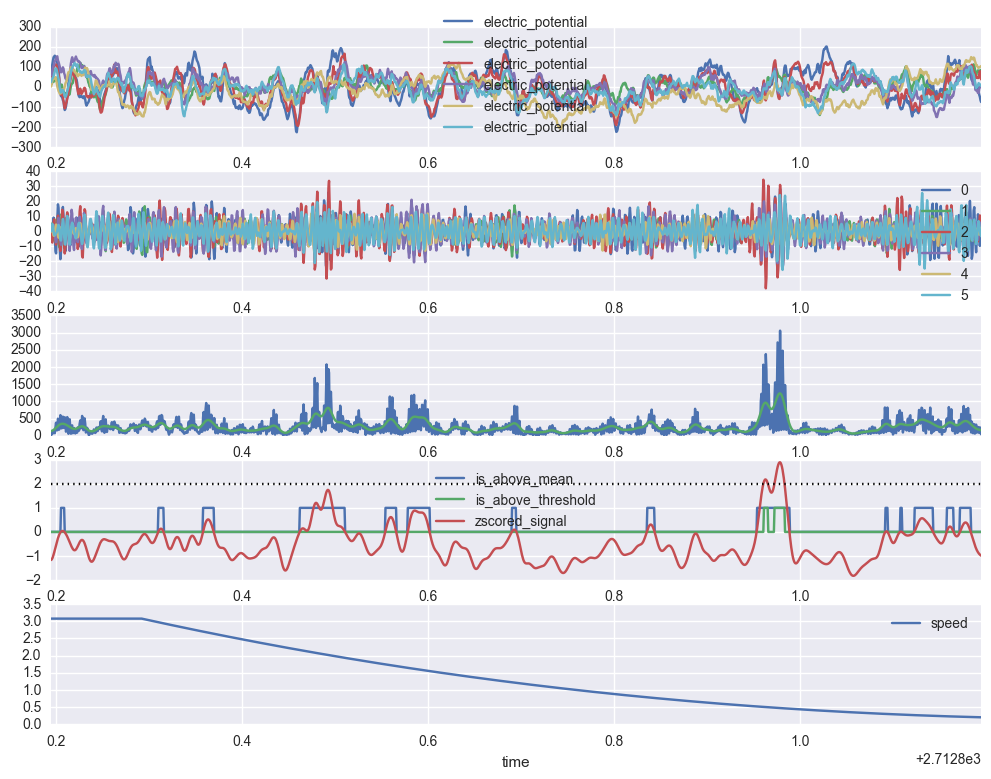

In [181]:
fig, axes = plt.subplots(5, figsize=(12,9))

pd.concat(CA1_lfps, axis=1).iloc[0:1500].plot(ax=axes[0])

pd.concat(filtered_lfps, axis=1).iloc[0:1500].plot(ax=axes[1])

combined_lfps.iloc[0:1500].plot(ax=axes[2])
smooth_combined_lfps.iloc[0:1500].plot(ax=axes[2])

pd.DataFrame({
        'zscored_signal': zscored_combined_lfps, 
        'is_above_mean': threshold_df.is_above_mean,
        'is_above_threshold': threshold_df.is_above_threshold
    }).iloc[0:1500].plot(ax=axes[3])
axes[3].axhline(2, color='black', linestyle=':')
position_df = data_processing.get_interpolated_position_dataframe(epoch_index, animals)
position_df.iloc[0:1500].plot(y='speed', ax=axes[4])

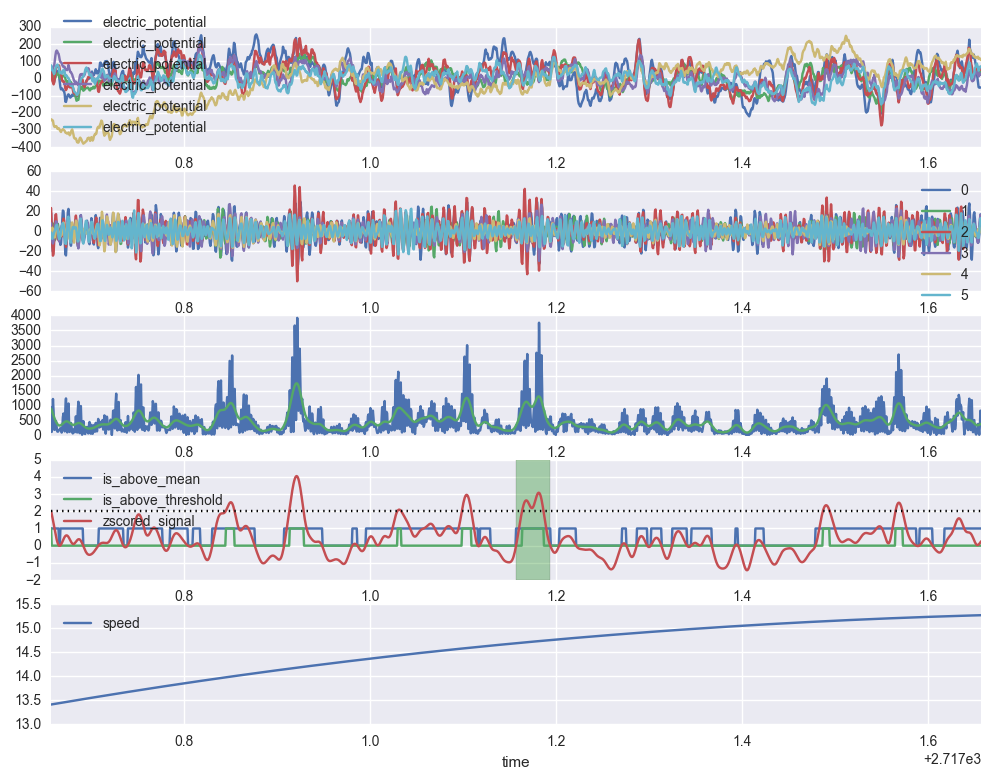

In [177]:
fig, axes = plt.subplots(5, figsize=(12,9))
candidate_ripple_start, candidate_ripple_end = candidate_ripple_times[0]

pd.concat(CA1_lfps, axis=1).loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[0])

pd.concat(filtered_lfps, axis=1).loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[1])

combined_lfps.loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[2])
smooth_combined_lfps.loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[2])

pd.DataFrame({
        'zscored_signal': zscored_combined_lfps, 
        'is_above_mean': threshold_df.is_above_mean,
        'is_above_threshold': threshold_df.is_above_threshold
    }).loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[3])
axes[3].axhline(2, color='black', linestyle=':')
axes[3].axvspan(candidate_ripple_start, candidate_ripple_end, facecolor='green', alpha=0.3)
position_df = data_processing.get_interpolated_position_dataframe(epoch_index, animals)
position_df.loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500, :].plot(y='speed', ax=axes[4])

In [128]:
ripple_detection.Kay_method(CA1_lfps)

[(2718.1574666666666, 2718.1941333333334),
 (2718.6941333333334, 2718.7441333333331),
 (2718.8307999999997, 2718.9088000000002),
 (2719.0981333333334, 2719.1387999999997),
 (2719.7754666666665, 2719.9334666666664),
 (2720.2414666666664, 2720.3681333333334),
 (2721.4328, 2721.5407999999998),
 (2723.3954666666668, 2723.4661333333333),
 (2728.5534666666667, 2728.6101333333331),
 (2730.1628000000001, 2730.2921333333334),
 (2731.7854666666667, 2731.8214666666668),
 (2734.6441333333332, 2734.7161333333333),
 (2734.9207999999999, 2735.0254666666665),
 (2736.9021333333335, 2736.9434666666666),
 (2738.2467999999999, 2738.3027999999999),
 (2738.3388, 2738.4354666666668),
 (2738.7981333333332, 2738.8521333333333),
 (2741.1394666666665, 2741.2241333333332),
 (2741.3388, 2741.4374666666668),
 (2741.4748, 2741.5194666666666),
 (2741.6614666666665, 2741.7714666666666),
 (2741.9387999999999, 2741.9741333333332),
 (2741.9821333333334, 2742.0387999999998),
 (2742.6828, 2742.7467999999999),
 (2744.176133

In [129]:
ripple_detection.get_epoch_ripples(epoch_index, animals, sampling_frequency=1500,
                                   ripple_detection_function=ripple_detection.Kay_method)

[(2723.3954666666668, 2723.4661333333333),
 (2731.7854666666667, 2731.8214666666668),
 (2742.6828, 2742.7467999999999),
 (2771.1068, 2771.1974666666665),
 (2785.1687999999999, 2785.2628),
 (2785.6048000000001, 2785.6487999999999),
 (2788.1061333333332, 2788.1341333333335),
 (2796.652133333333, 2796.6954666666666),
 (2829.0361333333331, 2829.0974666666666),
 (2835.7287999999999, 2835.8174666666664),
 (2846.1507999999999, 2846.2114666666666),
 (2855.2081333333331, 2855.2628),
 (2885.6867999999999, 2885.7147999999997),
 (2900.1468, 2900.2234666666668),
 (2900.6801333333333, 2900.8407999999999),
 (2915.4521333333332, 2915.5154666666667),
 (2942.6141333333335, 2942.6861333333331),
 (2944.0754666666667, 2944.1248000000001),
 (2944.1261333333332, 2944.2181333333333),
 (2944.3434666666667, 2944.3914666666665),
 (2944.5341333333331, 2944.5641333333333),
 (2946.6561333333334, 2946.7281333333331),
 (2947.3334666666665, 2947.3834666666667),
 (2953.3661333333334, 2953.4314666666664),
 (2953.8208, 2

## Multitaper

In [172]:
ripple_power = ripple_detection._get_ripple_power_multitaper(CA1_lfps[0], sampling_frequency=1500)

### Karlsson

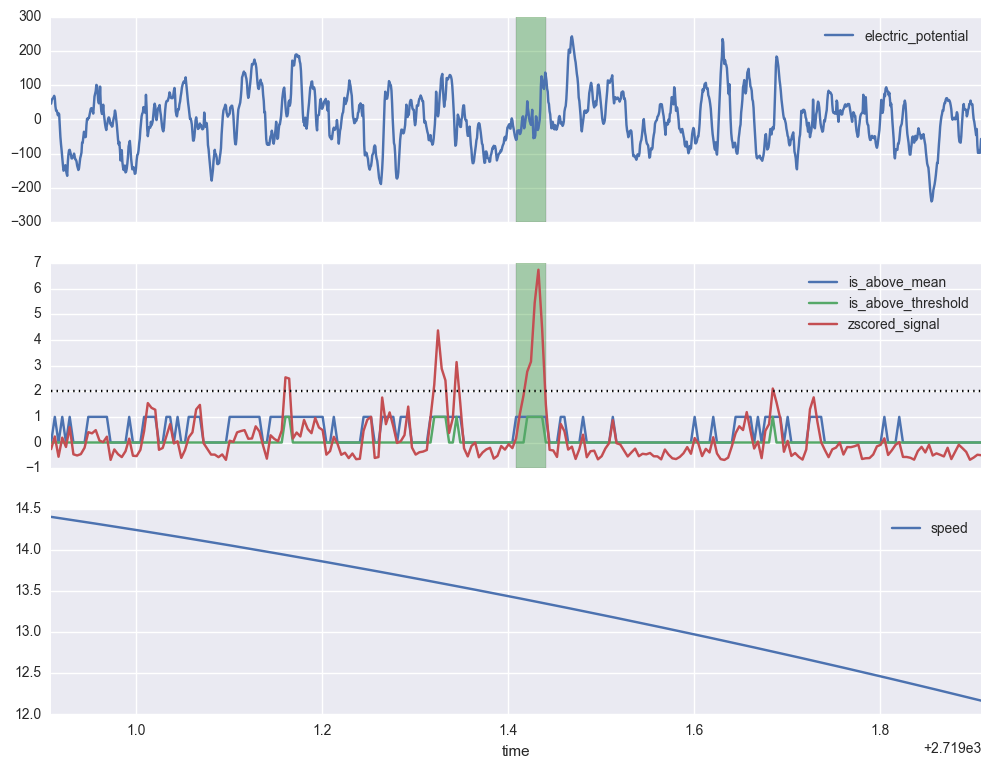

In [200]:
zscored_lfp = ripple_detection._zscore(ripple_power).values.flatten()
thresholded_lfp = ripple_detection._threshold_by_zscore(ripple_power, zscore_threshold=2)
extended_lfp = ripple_detection._extend_threshold_to_mean(
                    thresholded_lfp.is_above_mean,
                    thresholded_lfp.is_above_threshold,
                    minimum_duration=0.015)

fig, axes = plt.subplots(3, figsize=(12,9), sharex=True)
candidate_ripple_start, candidate_ripple_end = list(sorted(extended_lfp))[0]

CA1_lfps[0].loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[0])
axes[0].axvspan(candidate_ripple_start, candidate_ripple_end, facecolor='green', alpha=0.3)

pd.DataFrame({
        'zscored_signal': zscored_lfp,
        'is_above_mean': thresholded_lfp.is_above_mean,
        'is_above_threshold': thresholded_lfp.is_above_threshold
    }).loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[1])
axes[1].axhline(2, color='black', linestyle=':')
axes[1].axvspan(candidate_ripple_start, candidate_ripple_end, facecolor='green', alpha=0.3)
position_df = data_processing.get_interpolated_position_dataframe(epoch_index, animals)
position_df.loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500, :].plot(y='speed', ax=axes[2])

### Kay

In [203]:
ripple_power = [ripple_detection._get_ripple_power_multitaper(lfp, sampling_frequency=1500)
                for lfp in CA1_lfps]

In [213]:
combined_lfps = np.sum(pd.concat(ripple_power, axis=1) ** 2, axis=1)
zscored_combined_lfps = ripple_detection._zscore(np.sqrt(combined_lfps)).values.flatten()
smooth_combined_lfps = combined_lfps
threshold_df = ripple_detection._threshold_by_zscore(np.sqrt(smooth_combined_lfps),
                                    zscore_threshold=2)

candidate_ripple_times = list(sorted(ripple_detection._extend_threshold_to_mean(
        threshold_df.is_above_mean, threshold_df.is_above_threshold,
        minimum_duration=0.015)))

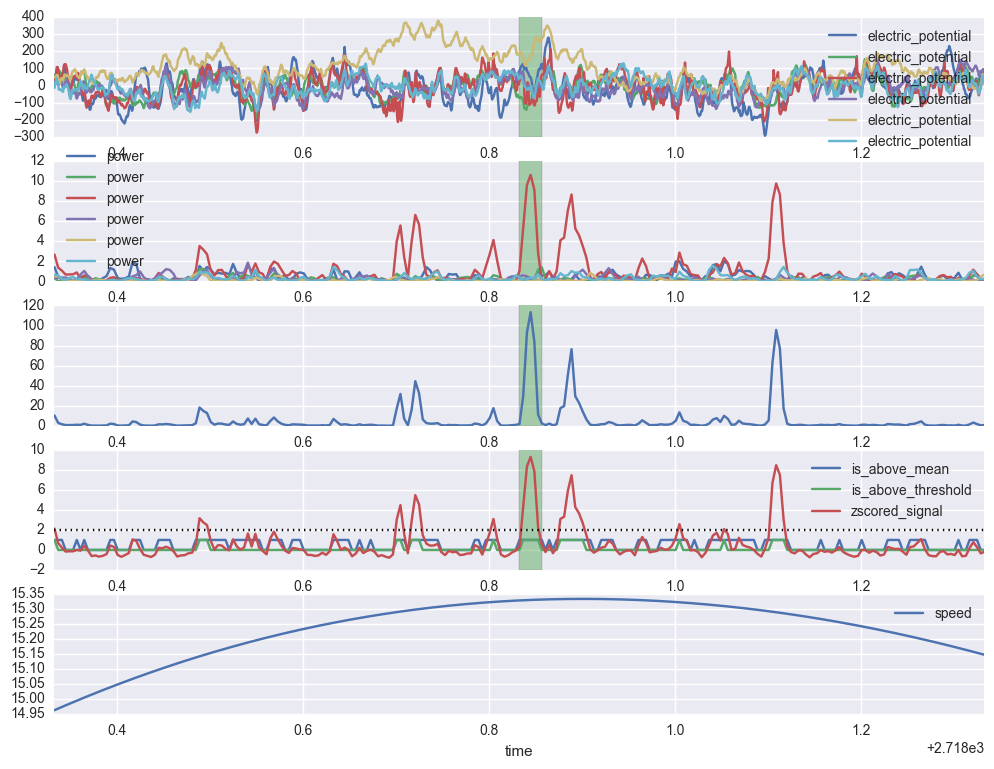

In [215]:
fig, axes = plt.subplots(5, figsize=(12,9))
candidate_ripple_start, candidate_ripple_end = candidate_ripple_times[0]

pd.concat(CA1_lfps, axis=1).loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[0])
axes[0].axvspan(candidate_ripple_start, candidate_ripple_end, facecolor='green', alpha=0.3)

pd.concat(ripple_power, axis=1).loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[1])
axes[1].axvspan(candidate_ripple_start, candidate_ripple_end, facecolor='green', alpha=0.3)

combined_lfps.loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[2])
axes[2].axvspan(candidate_ripple_start, candidate_ripple_end, facecolor='green', alpha=0.3)

pd.DataFrame({
        'zscored_signal': zscored_combined_lfps, 
        'is_above_mean': threshold_df.is_above_mean,
        'is_above_threshold': threshold_df.is_above_threshold
    }).loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500].plot(ax=axes[3])
axes[3].axhline(2, color='black', linestyle=':')
axes[3].axvspan(candidate_ripple_start, candidate_ripple_end, facecolor='green', alpha=0.3)
position_df = data_processing.get_interpolated_position_dataframe(epoch_index, animals)
position_df.loc[candidate_ripple_start - 0.500:candidate_ripple_start + 0.500, :].plot(y='speed', ax=axes[4])

## Comparing Ripple Detection Methods

### Compute time

In [219]:
%time ripple_times_Karlsson = ripple_detection.get_epoch_ripples(epoch_index, animals, sampling_frequency=1500, ripple_detection_function=ripple_detection.Karlsson_method)

CPU times: user 2min 10s, sys: 4.83 s, total: 2min 15s
Wall time: 2min 31s


In [221]:
%time ripple_times_Kay = ripple_detection.get_epoch_ripples(epoch_index, animals, sampling_frequency=1500, ripple_detection_function=ripple_detection.Kay_method)

CPU times: user 1min 3s, sys: 2.31 s, total: 1min 6s
Wall time: 1min 7s


In [225]:
%time ripple_times_Karlsson_multitaper = ripple_detection.get_epoch_ripples(epoch_index, animals, sampling_frequency=1500, ripple_detection_function=ripple_detection.mulititaper_Karlsson_method)

CPU times: user 2h 8min 12s, sys: 6min 8s, total: 2h 14min 21s
Wall time: 2h 29min 24s


In [273]:
%time ripple_times_Kay_multitaper = ripple_detection.get_epoch_ripples(epoch_index, animals, sampling_frequency=1500, ripple_detection_function=ripple_detection.multitaper_Kay_method)

CPU times: user 1h 57min 53s, sys: 2min 52s, total: 2h 46s
Wall time: 2h 5min 21s


### Number of ripples, Average duration of ripples

In [277]:
print('Karlsson method, # of Ripples: {0}'.format(len(ripple_times_Karlsson)))
print('Kay method, # of Ripples: {0}'.format(len(ripple_times_Kay)))
print('Karlsson multitaper method, # of Ripples: {0}'.format(len(ripple_times_Karlsson_multitaper)))
print('Kay multitaper method, # of Ripples: {0}'.format(len(ripple_times_Kay_multitaper)))

Karlsson method, # of Ripples: 471
Kay method, # of Ripples: 155
Karlsson multitaper method, # of Ripples: 209
Kay multitaper method, # of Ripples: 75


In [278]:
average_duration = lambda x: np.mean(np.diff(np.asarray(x)))

print('Karlsson method, average duration (seconds): {:0.3f}'.format(average_duration(ripple_times_Karlsson)))
print('Kay method, average duration (seconds): {:0.3f}'.format(average_duration(ripple_times_Kay)))
print('Karlsson multitaper method, average duration (seconds): {:0.3f}'.format(average_duration(ripple_times_Karlsson_multitaper)))
print('Kay multitaper method, average duration (seconds): {:0.3f}'.format(average_duration(ripple_times_Kay_multitaper)))

Karlsson method, average duration (seconds): 0.069
Kay method, average duration (seconds): 0.074
Karlsson multitaper method, average duration (seconds): 0.041
Kay multitaper method, average duration (seconds): 0.055


### Visualization of ripples

In [286]:
import ipywidgets

def browse_ripples(lfps, ripple_times):
    num_lfps = len(lfps)
    num_ripples = len(ripple_times)
    def plot_ripple(ripple_ind):
        fig, axes = plt.subplots(num_lfps, figsize=(num_lfps * 3, 9), sharex=True, sharey=True)
        ripple_start, ripple_end = ripple_times[ripple_ind]
        for lfp_ind, ax in enumerate(axes.flatten()):
            lfps[lfp_ind].loc[ripple_start - .5:ripple_start + .5].plot(ax=ax)
            ax.axvspan(ripple_start, ripple_end, facecolor='green', alpha=0.3)
        plt.suptitle('Ripple #{:d} ({:0.3f}, {:0.3f})'.format(ripple_ind+1, ripple_start, ripple_end), fontsize=18)
    ipywidgets.interact(plot_ripple, ripple_ind=ipywidgets.IntSlider(value=0, min=0, max=num_ripples-1, continuous_update=False))

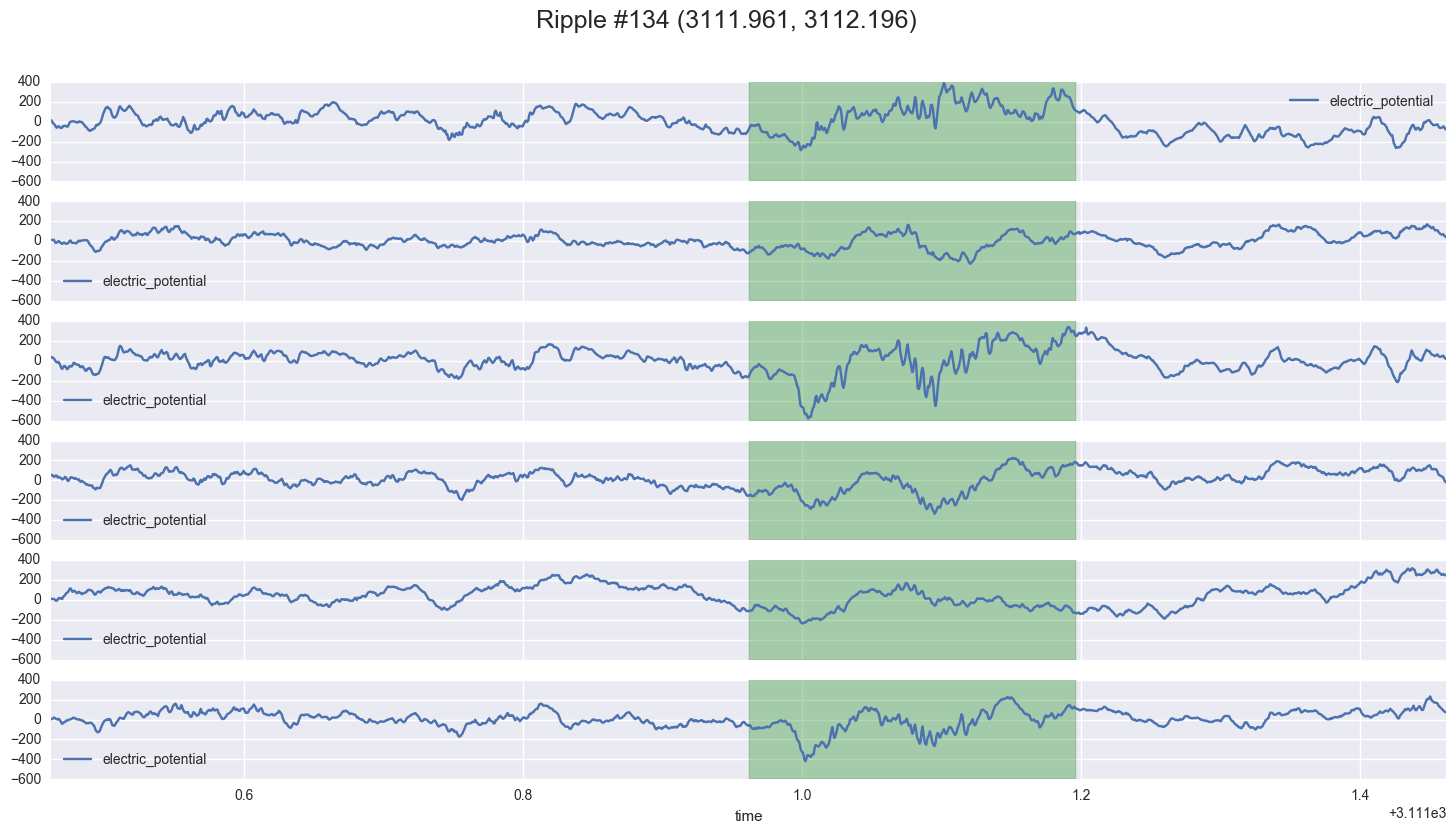

In [287]:
browse_ripples(CA1_lfps, ripple_times_Karlsson)

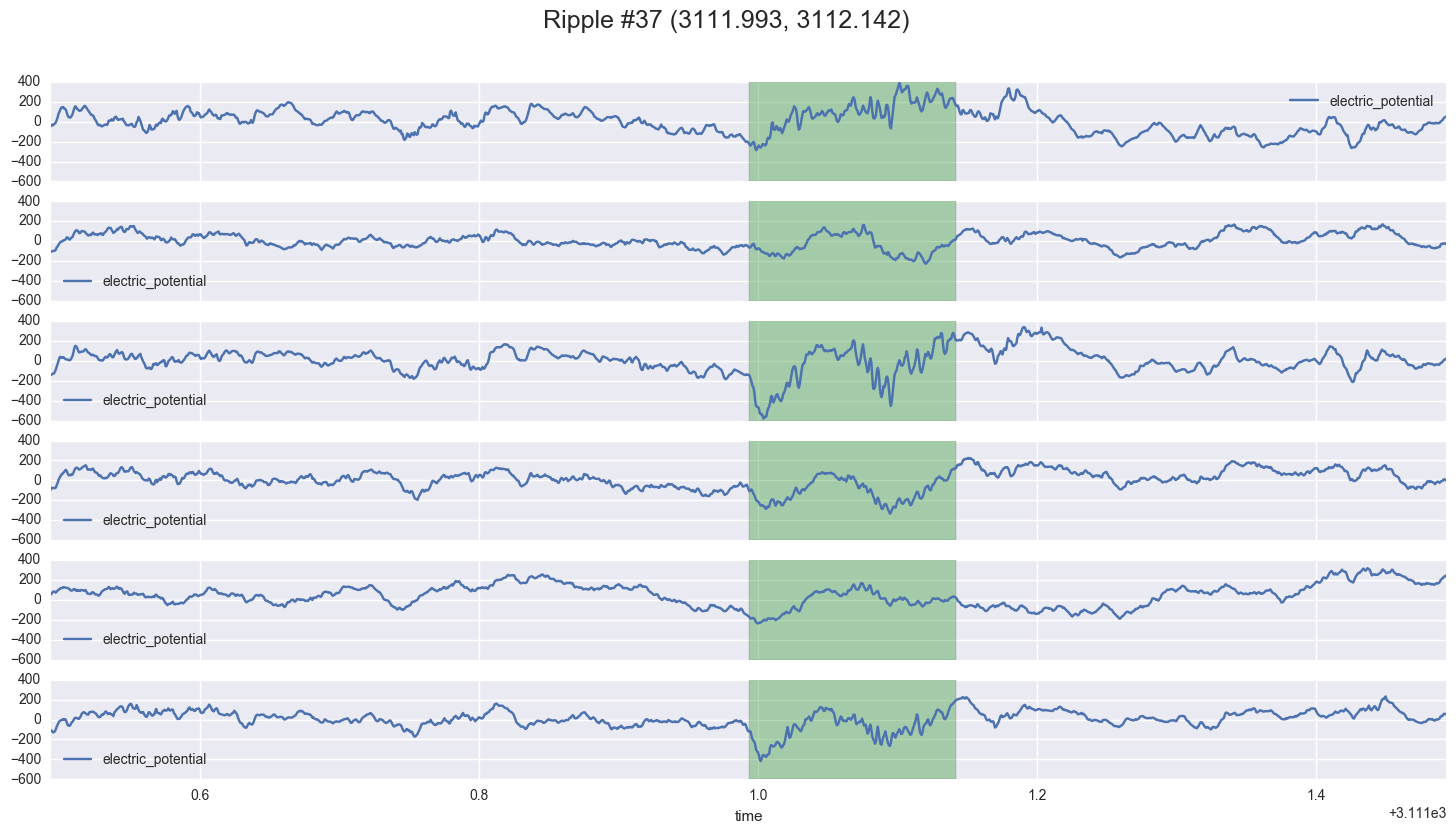

In [288]:
browse_ripples(CA1_lfps, ripple_times_Kay)

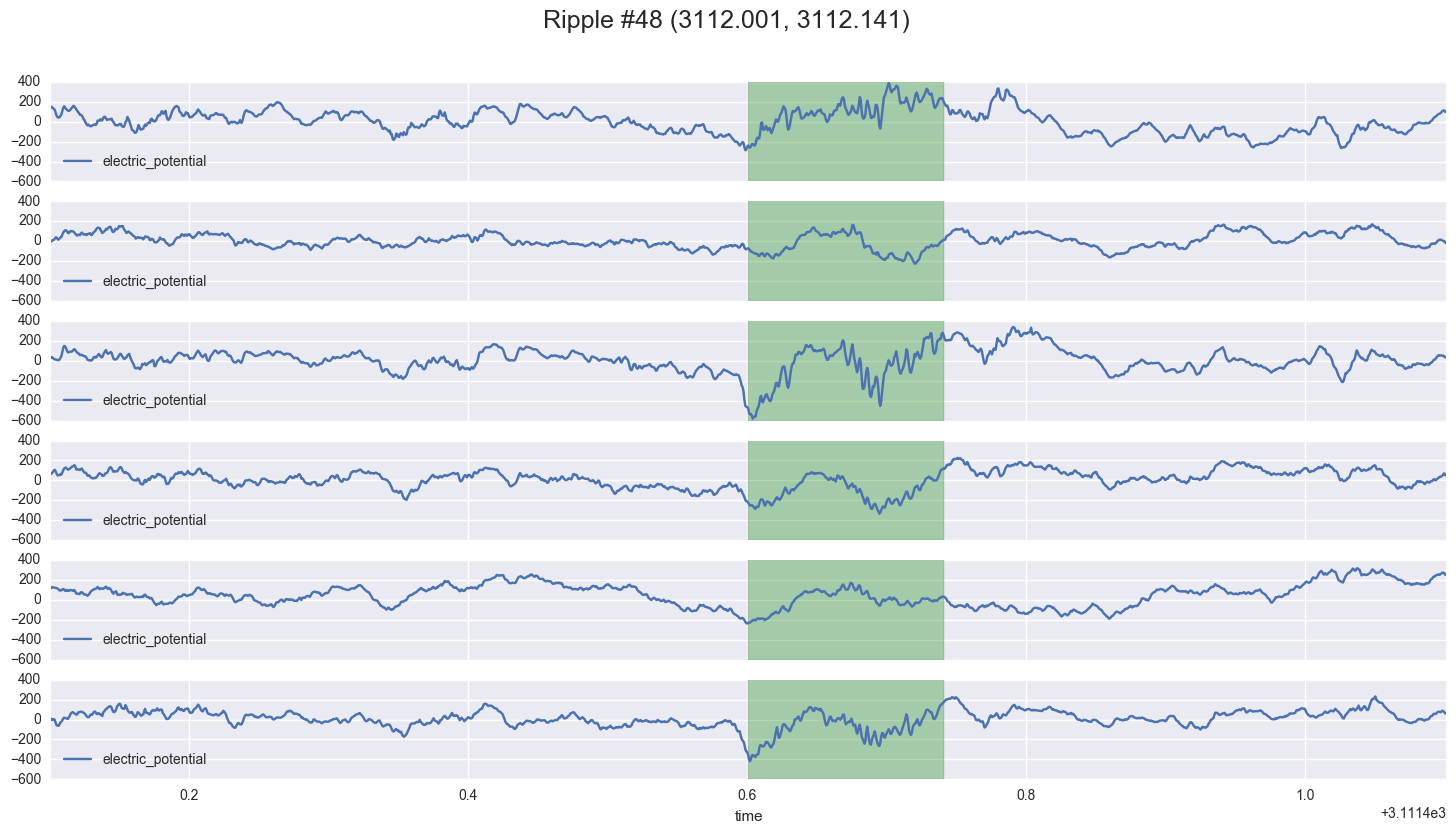

In [289]:
browse_ripples(CA1_lfps, ripple_times_Karlsson_multitaper)

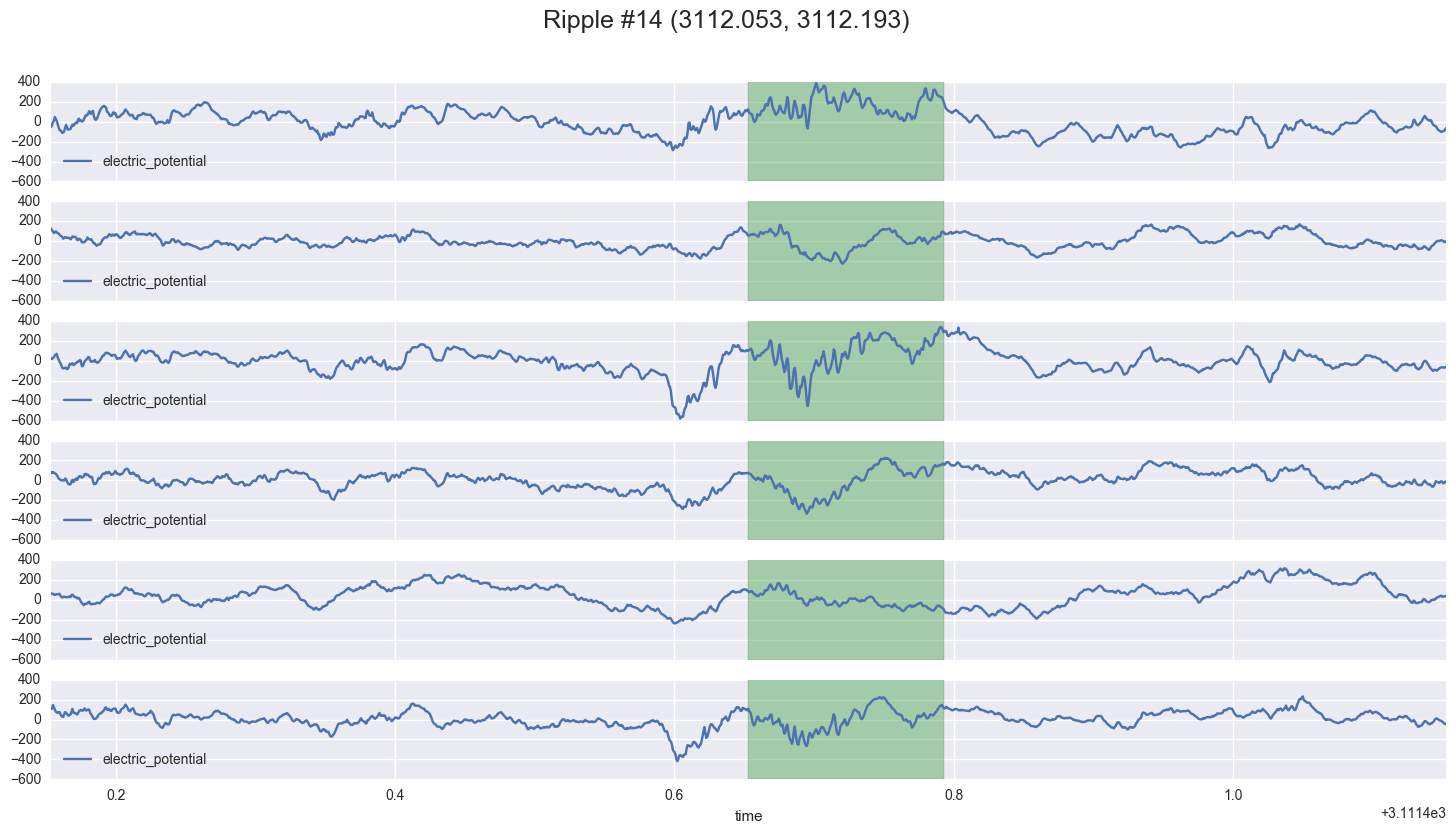

In [290]:
browse_ripples(CA1_lfps, ripple_times_Kay_multitaper)

### Compare times

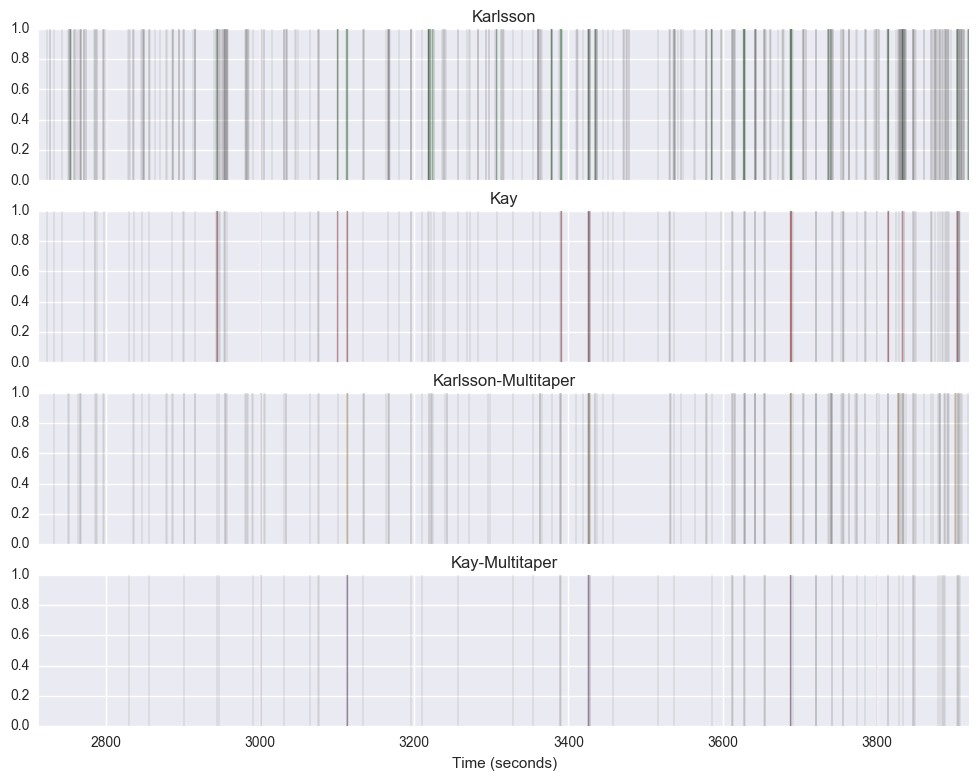

In [296]:
fig, axes = plt.subplots(4, figsize=(12,9), sharex=True)
time_extent = CA1_lfps[0].index.min(), CA1_lfps[0].index.max()

for ripple_start, ripple_end in ripple_times_Karlsson:
    axes[0].axvspan(ripple_start, ripple_end, facecolor='green', alpha=0.3)
axes[0].set_title('Karlsson')
axes[0].set_xlim(time_extent)


for ripple_start, ripple_end in ripple_times_Kay:
    axes[1].axvspan(ripple_start, ripple_end, facecolor='red', alpha=0.3)
axes[1].set_title('Kay')
axes[1].set_xlim(time_extent)

for ripple_start, ripple_end in ripple_times_Karlsson_multitaper:
    axes[2].axvspan(ripple_start, ripple_end, facecolor='orange', alpha=0.3)
axes[2].set_title('Karlsson-Multitaper')
axes[2].set_xlim(time_extent)

for ripple_start, ripple_end in ripple_times_Kay_multitaper:
    axes[3].axvspan(ripple_start, ripple_end, facecolor='purple', alpha=0.3)
axes[3].set_title('Kay-Multitaper')
axes[3].set_xlim(time_extent)

axes[3].set_xlabel('Time (seconds)')